# __Segmentacion de clientes en un comercio online: Construir Modelos__

## Importar librerías

In [ ]:
# librerias para el dataframe y la visualizacion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# librerias para la clusterizacion
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram


## Cargar los datos

In [13]:
# datos con valores originales
rfm = pd.read_csv('./data/rfm.csv')
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [14]:
# datos con valores escalados
rfm_df_scaled = pd.read_csv('./data/rfm_df_scaled.csv')
rfm_df_scaled.head()

,Monetary,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Construir Modelo K-Means

Este modelo requiere inicializarlo con un número de clustering definido. Como desconocemos el valor, vamos a probar con diferentes técnicas para encontrar el K óptimo.

### _Encontrar el número óptimo de clusteres_

Vamos a implementar dos técnicas muy comunes para encontrar el K adecuado.

__Método del codo__

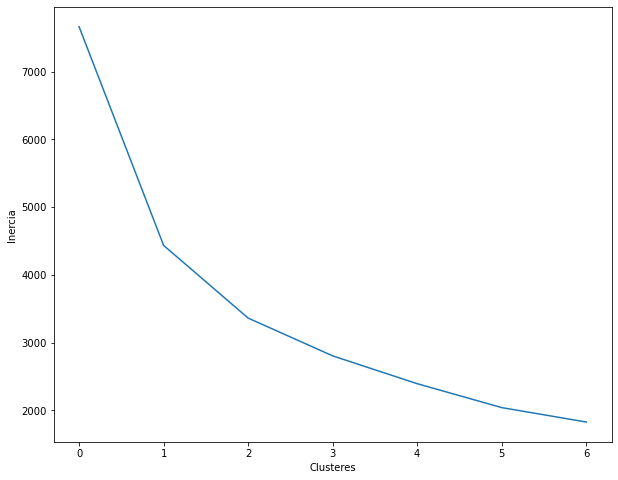

In [17]:
# lista para guardar la inercia de cada K
inercia = []

# definir el rango de K a probar
K = range(2, 9)

# iteramos sobre el modelo para cada valor de K
for n_cluster in K:
    kmeans = KMeans(n_clusters=n_cluster, max_iter=50, n_init=10, random_state=42)
    kmeans.fit(rfm_df_scaled)
    inercia.append(kmeans.inertia_)

# visualizamos los resultados
plt.figure(figsize=(10, 8))
plt.plot(inercia)
plt.xlabel('Clusteres')
plt.ylabel('Inercia')
plt.show()

> El gráfico muestra la mayor pérdida de inercia en el cluster 1. Sin embargo, 1 sólo cluster no nos aporta información relevante. 

> El cluster 3 presenta un punto de inflexión en cuanto a la pérdida de inercia. Es un buen valor a considerar.

__Índice de Silueta__

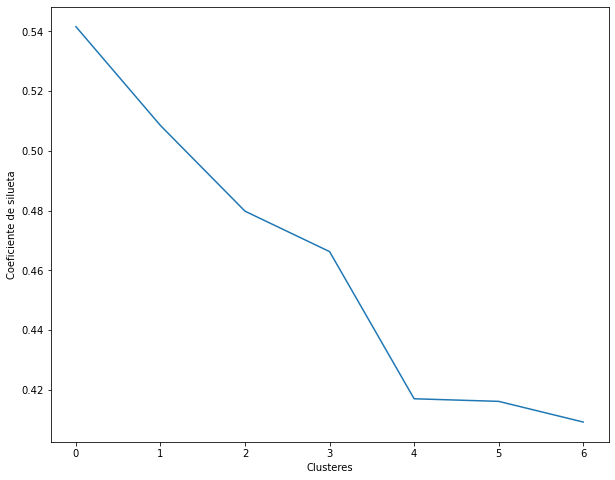

In [18]:
# lista para guardar los indice de silueta para cada cluster
index_silueta = []

# rango de K a probar
K = range(2, 9)

# itermaos el modelo para cada valor de K
for n_cluster in K:
    kmeans = KMeans(n_clusters=n_cluster, n_init=10, max_iter=50, random_state=42)
    y_pred = kmeans.fit_predict(rfm_df_scaled)
    index_silueta.append(silhouette_score(rfm_df_scaled, y_pred))

# visualizamos resultados
plt.figure(figsize=(10, 8))
plt.plot(index_silueta)
plt.xlabel('Clusteres')
plt.ylabel('Coeficiente de silueta')
plt.show()

> La grafica muestra en el cluster 3 el coeficiente de silueta no decae tanto.

> En ambos graficos la sugerencia es K=3, por lo que lo seleccionamos como el K óptimo.

### _Mejor Modelo K-Means_

Ambos métodos sugieren que con un número de cluster igual a 3 podemos obtener un modelo de clusterización óptimo. 

In [19]:
# definimos el modelo
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=50, random_state=42)

# entrenamos y obtenemos las predicciones
y_predict = kmeans.fit(rfm_df_scaled)

# asignamos la etiqueta de clusterizacion a cada cliente del df
rfm['Cluster_K'] = kmeans.labels_
rfm.head() 

,CustomerID,Monetary,Frequency,Recency,Cluster_K
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


Vamos a obtener el índice de silueta del modelo seleccionado para realizar comparaciones al final y decidir cuál es el mejor a partir de esta métrica.

In [20]:
print(silhouette_score(rfm_df_scaled, y_pred))

0.409200624135143


> El indice de silueta general del modelo es bueno.

## Construir modelo Hierarchical Clustering

Vamos a utilizar el modelo de aglomeración jerárquica para clusterizar los clientes de acuerdo a RFM. Vamos a probar con diferentes métodos hasta encontrar aquel con el mejor resultado y de esta forma etiquetar a cada cliente.

### _Single Linkage_

la distancia entre dos grupos se define como la distancia más corta entre dos puntos en cada grupo.

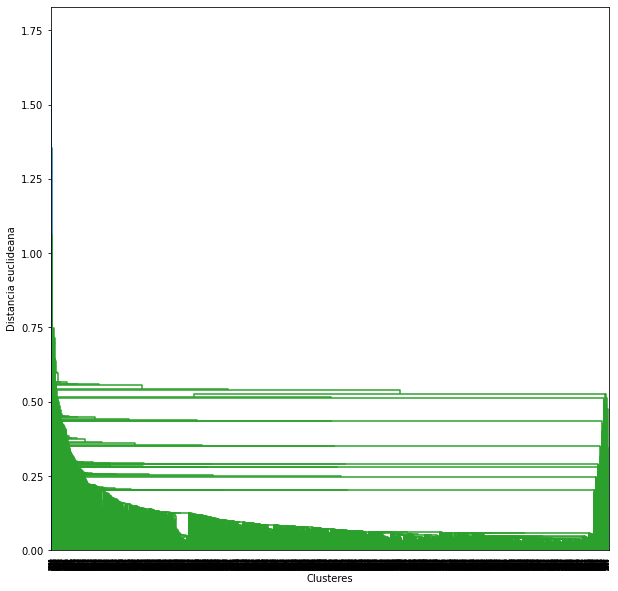

In [23]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='single', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> No muestra claridad en cuanto a los clusteres que se pueden formar.

> Logra percibirse dos grupos: azul y verde, este último siendo más predominante.

### _Complete linkage_

La distancia entre dos grupos se define como la distancia más larga entre dos puntos en cada grupo.

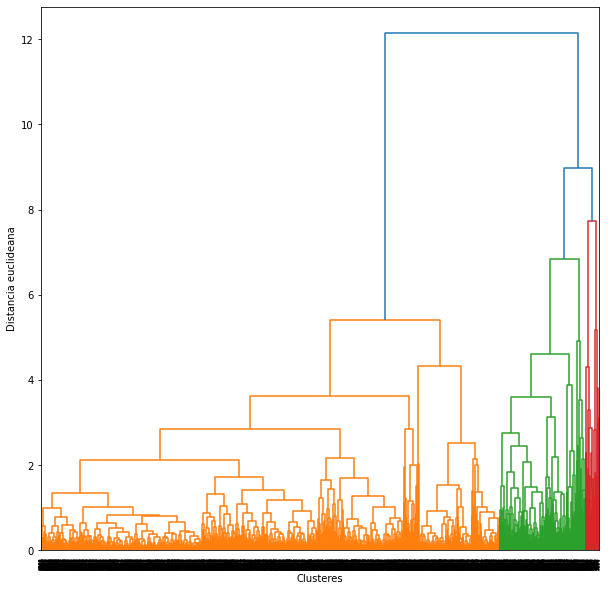

In [24]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='complete', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> Se logra diferenciar 3 clusteres

> 2 de los clusteres son muy dominantes respecto al tercero.

> Arroja mejores resultados que el dendograma anterior.

### _Average linkage_

La distancia entre dos grupos se define como la distancia promedio entre cada punto de un grupo y cada punto del otro grupo.

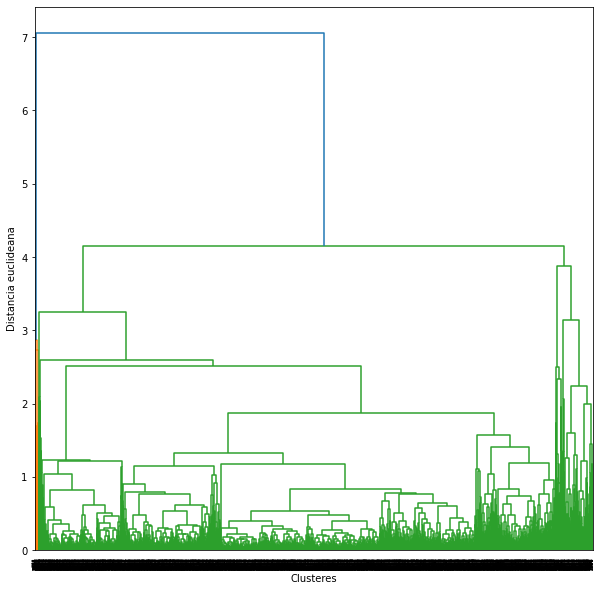

In [25]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='average', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> Se evidencia la diferencia entre dos clusteres.

> No es tan claro pero se evidencia hasta 3 clusteres.

> Hay un cluster dominante frente al resto.

### _Warm_

Realiza un monton de operaciones en el que cada dato se lleva a otro cluster, evalúa su varianza y se queda con la varianza que de menor.

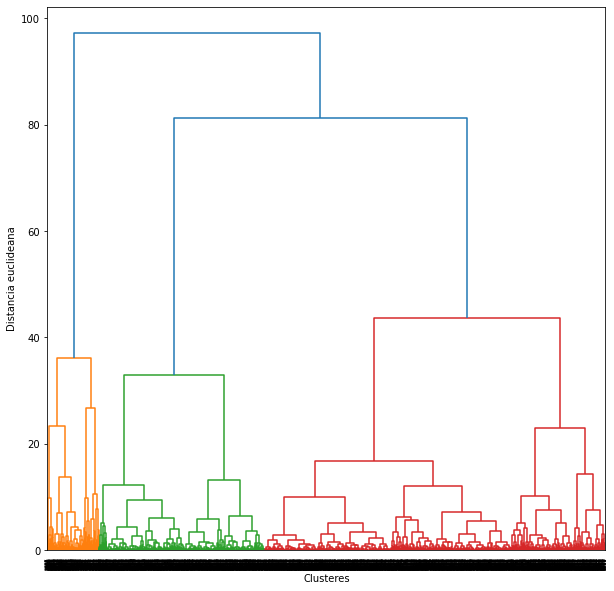

In [26]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='ward', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> Se evidencia una mejor separación entre 3 clusteres.

> Los 3 clusteres mantienen una buena distancia entre sí, lo que indica una excelente clusterización.

### _Mejor Modelo Hierarchical Clustering_

De los métodos probados, nos quedamos con Warm debido a su excelente diferenciación de clusteres. Vamos a calcular el índice de silueta general para 2 y 3 clusteres y así encontrar la mejor opción.

In [27]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# para 2 clusteres
hc_2 = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
y_hc_2 = hc_2.fit_predict(rfm_df_scaled)
print(silhouette_score(rfm_df_scaled, y_hc_2))

0.5788705653522203


In [28]:
# para 3 clusteres
hc_3 = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
y_hc_3 = hc_3.fit_predict(rfm_df_scaled)
print(silhouette_score(rfm_df_scaled, y_hc_3))

0.4643083907731691


> Evidentemente, con 2 cluster obtenemos un índice de silueta mucho mayor debido a que dos de clusteres estan bien distanciados. Sin embargo, diferenciar los clientes en 2 grupos no nos brinda la informacion que necesitamos.

> Para 3 clusteres obtenemos un índice de silueta bastante bueno y 3 grupos de clientes si podria ser relevante en cuanto a la creacion de campañas.

> Nos quedamos con la clusterizacion para K=3 utilizando el método Warm. Guardamos la etiqueta de cada cliente en el dataframe

In [29]:
rfm['cluster_hc'] = y_hc_3
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_K,cluster_hc
0,12346.0,0.00,2,325,1,2
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,1,2


## Construir modelo DBSCAN

Este modelo requiere determinar un rango de valores de epsilon (eps) y un rango de número mínimo de puntos vecinos dentro del radio eps. Procedemos a calcular cada rango.

### Rango óptimo de epsilon

In [33]:
from sklearn.neighbors import NearestNeighbors

# calculo del vecino mas cercano
neighbors = NearestNeighbors(n_neighbors=2)
# ajuste del objeto a los datos
neighbors_fit = neighbors.fit(rfm_df_scaled)
# guardamos la distancia e indice de cada punto
distances, indices = neighbors_fit.kneighbors(rfm_df_scaled)

In [34]:
# ordenamos las distancias
distances = np.sort(distances, axis=0)
# tomar la distancia del vecino mas cercano de cada dato
distances = distances[:,1]

Creamos el gráfico de k-distancias donde se ordenan la distancias al k-ésimo vecino más cercano. El codo generado indica un buen rango de valores para eps.

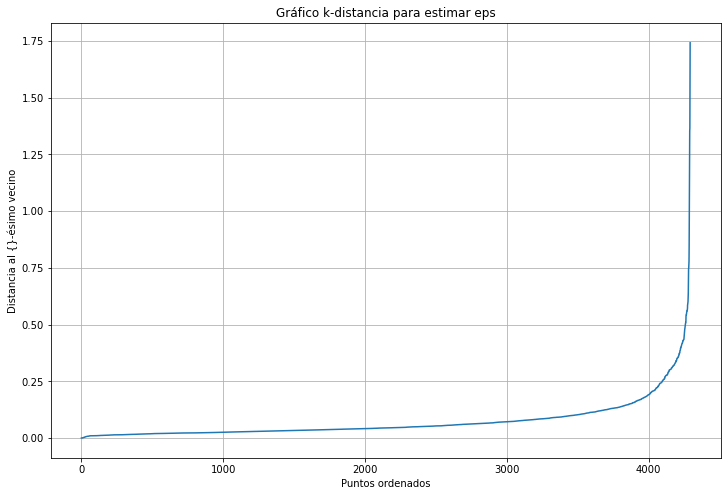

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(distances)
plt.ylabel("Distancia al {}-ésimo vecino")
plt.xlabel("Puntos ordenados")
plt.title("Gráfico k-distancia para estimar eps")
plt.grid(True)
plt.show()

> El codo se encuentra entre 0.10 y 0.55 por lo que elegimos ese rango como rango de epsilon

In [64]:
# rango de epsilon
eps_values = np.arange(0.10, 0.60, 0.05)

### Rango óptimo de min_samples

Para definir este rango, vamos a utilizar una regla empírica que indica que el valor mínimo es 3 y el valor máximo es el doble del mínimo. Sin embargo, es importante tener en cuenta que este rango se suele ajustar mejor por ensayo y error. Para este caso, lo definimos entre 3 y 7:

In [65]:
# rango de min_samples
min_samples = np.arange(3, 8)

### Obtener predicciones del modelo DBSCAN con las diferentes combinaciones de parámetros

In [66]:
# libreria para combinar parametros
from itertools import product

# combinatoria de parametros
dbscan_params = list(product(eps_values, min_samples))

# lista para almacenar el numero de cluster
n_cluster = []

# lista para almacenar el indice de silueta
sil_score = []

# iteramos el modelo con la diferentes combinaciones de parametros
for p in dbscan_params:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(rfm_df_scaled)
    
    try:
        sil_score.append(silhouette_score(rfm_df_scaled, y_dbscan))
    except:
        sil_score.append(0)

    n_cluster.append(len(np.unique(y_dbscan)))

Creamos un datarame con las predicciones del modelo junto a sus correspondientes parámetros.

In [67]:
df_param_tunning = pd.DataFrame.from_records(dbscan_params, columns=['Eps', 'Min_samples'])
df_param_tunning['Sil_score'] = sil_score
df_param_tunning['N_clusters'] = n_cluster

df_param_tunning.head()

,Eps,Min_samples,Sil_score,N_clusters
0,0.1,3,-0.536853,77
1,0.1,4,-0.557983,37
2,0.1,5,-0.538761,26
3,0.1,6,-0.438660,20
4,0.1,7,-0.414642,14


Creamos dos tablas dinámicas a partir del dataframe anterior para visualizar mejor el rendimiento de las distintas combinaciones de parámetros en DBSCAN.

In [68]:
pivot_1 = pd.pivot_table(df_param_tunning, values='Sil_score', columns='Eps', index='Min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values='N_clusters', columns='Eps', index='Min_samples')

pivot_1

Eps,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55
Min_samples,,,,,,,,,,
3,-0.536853,-0.410187,-0.213680,-0.127787,0.143016,-0.067399,-0.027248,0.512390,0.226891,0.211482
4,-0.557983,-0.403675,-0.133179,0.010685,0.041410,0.143179,0.052877,0.461600,0.593632,0.606081
5,-0.538761,-0.425480,-0.133731,-0.114117,0.236642,0.442860,0.199082,0.458037,0.597207,0.613268
6,-0.438660,-0.479183,-0.020455,0.291444,0.121581,0.544347,0.445233,0.131476,0.547516,0.551484
7,-0.414642,-0.427723,0.306661,-0.043372,0.126959,0.494953,0.445894,0.460301,0.637395,0.624497


### Heatmap del índice de silueta y del número de clusteres

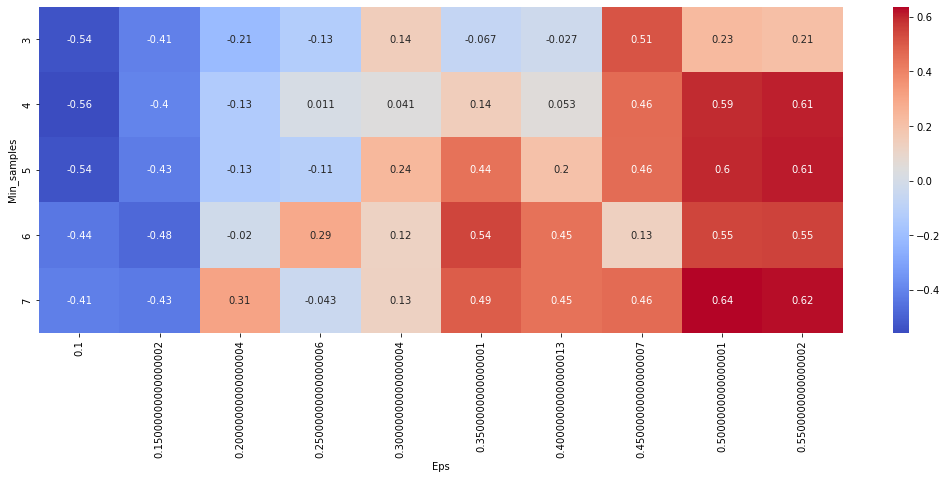

In [69]:
# heatmap del indice de silueta
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

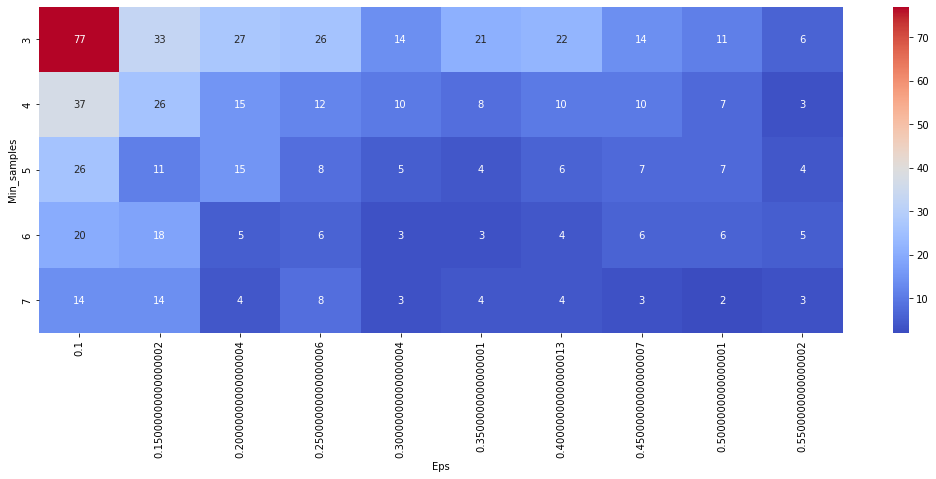

In [70]:
# heatmap del numero de cluster
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

> Comparando ambos heatmaps, vemos que el índice de silueta más alto (0.55) corresponde a un total de 3 clusteres que no es el más bajo. Por tanto, esta elección se considera buena y corresponde a los parámetros eps=0.55 y min_sample=7

> Vamos a entrenar DBSCAN con los parámetros seleccionados para contrastar el resultado que se obtenga con el índice de silueta dado en el heatmap.

In [81]:
dbscan_train = DBSCAN(eps=0.55, min_samples=7)
y_dbscan = dbscan_train.fit_predict(rfm_df_scaled)
print(silhouette_score(rfm_df_scaled, y_dbscan))

0.6244971448289627


> Como vemos, el indice de silueta que arroja el modelo concuerda con el valor presentado en el heatmap.

> Guardamos las predicciones de DBSCAN en el dataframe con los datos originales 'rfm'

In [82]:
rfm['Cluster_dbscan'] = y_dbscan
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_K,cluster_hc,Cluster_dbscan
0,12346.0,0.00,2,325,1,2,0
1,12347.0,4310.00,182,1,0,1,0
2,12348.0,1797.24,31,74,2,0,0
3,12349.0,1757.55,73,18,2,0,0
4,12350.0,334.40,17,309,1,2,0


## Elección del mejor modelo

Para la elección del mejor modelo, nos basamos en el índice de silueta general de cada uno, así como en la visualización de los clusteres formados.

- K-Means: 0.409200624135143
- Hierarchical Clustering: 0.4643083907731691
- DBSCAN: 0.6060806889707244

Según el índice de silueta, el modelo DBSCAN arroja los mejores resultados. Ahora, vamos a visualizar los clusteres formados con un scatterplot para cada modelo.

### _Visualización de la clusterizacion por modelo_

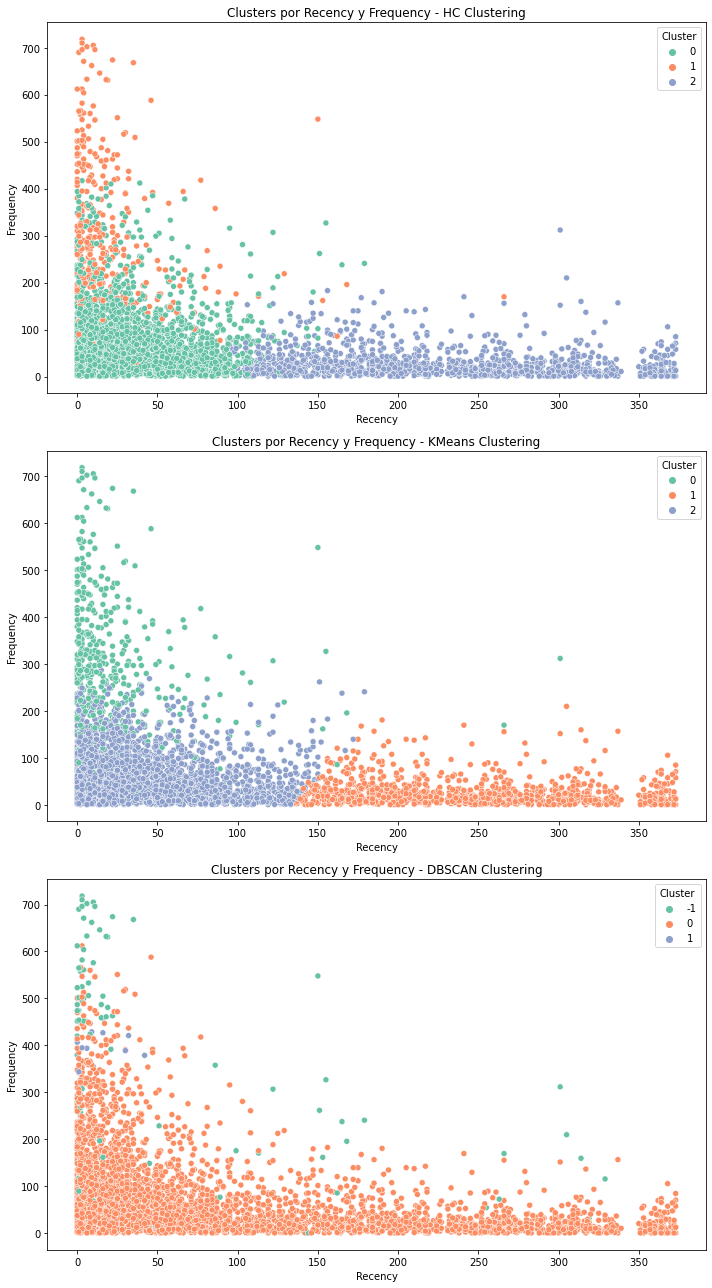

In [88]:
# Definir los diferentes hue y sus títulos
hues = ['cluster_hc', 'Cluster_K', 'Cluster_dbscan']
titles = ['HC Clustering', 'KMeans Clustering', 'DBSCAN Clustering']

# Crear subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Iterar para crear cada subplot
for i, ax in enumerate(axes):
    sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue=hues[i], palette='Set2', ax=ax)
    ax.set_title(f'Clusters por Recency y Frequency - {titles[i]}')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.legend(title='Cluster')

plt.tight_layout()
plt.show()


> A pesar que el modelo DBSCAN tiene el mayor índice de silueta, no logra ser efectivo diferenciando los 3 clusteres. Esto puede deberse a la agrupacion tan compacta de los datos que hace que el modelo no logre diferenciar correctamente los clusteres.

> El modelo K-Means, a pesar de tener el índice de silueta más bajo, genera una excelente diferenciación de los tres clusteres. Seleccionamos este modelo y ahora analizamos cada variable.

> Es importante resaltar que se probó con diferentes combinaciones de parámetros en DBSCAN y aún así, no se logró obtener una buena diferenciación de los clusteres. Esto indica que el modelo no funciona eficazmente en el conjunto de datos. 

## Conclusiones

### _Recency vs Frequency (K-Means)_

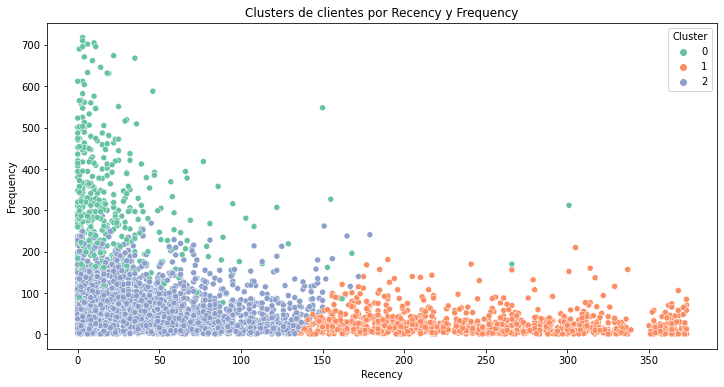

In [90]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster_K', palette='Set2')
plt.title('Clusters de clientes por Recency y Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

> Se evidencian los tres clusteres bien definidos. 

> Los clientes del cluster 0, hacen muy a menudo sus pedidos por lo que la cantidad de días que transcurre antes de pedir nuevamente es bajo.

> Los clientes del cluster 1, van a la tienda con una frecuencia baja media y por tanto, su recency está entre 0 y 140 dias.

> los clientes del cluster 2, presentan una frecuencia baja para hacer pedidos y por tanto tienden a durar más días antes de pedir nuevamente.

### _Monetary vs Recency (K-Means)_

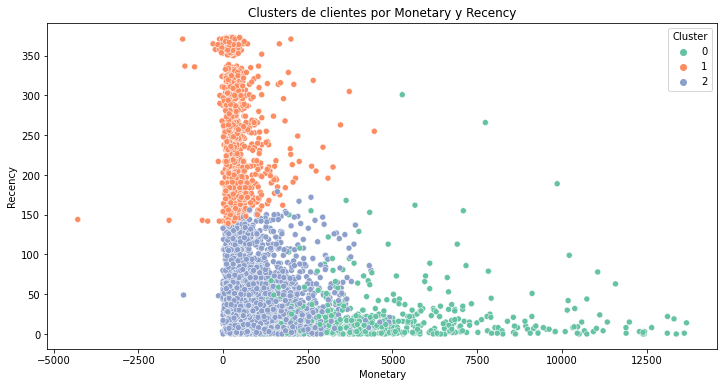

In [92]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=rfm, x='Monetary', y='Recency', hue='Cluster_K', palette='Set2')
plt.title('Clusters de clientes por Monetary y Recency')
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.legend(title='Cluster')
plt.show()

> Se evidencian ingresos negativos de clientes lo cual debe analizarse.

> El cluster 0 corresponde a los clientes que hacen pedidos frecuentemente pero que gastan poco dinero.

> El cluster 1 corresponde a los clientes que hacen pedidos no tan frecuentemente con un gasto poco mas que los del cluster 0.

> El cluster 2 corresponde a los clientes que hacen pocos pedidos pero que gastan mucho más al comprar.

### _Monetary vs Frequency (K-Means)_

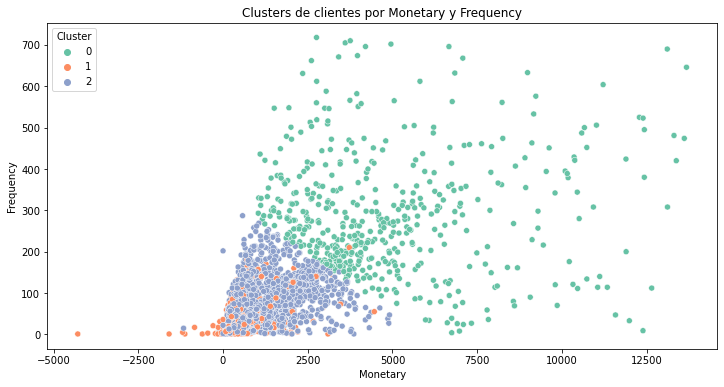

In [93]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=rfm, x='Monetary', y='Frequency', hue='Cluster_K', palette='Set2')
plt.title('Clusters de clientes por Monetary y Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

__Cluster 0__

> Son los clientes mas frecuentes y con altos gastos en la tienda. Esto los hace ser los clientes más valiosos.

__Cluster 1__

> Corresponde a los clientes de frecuencia baja y poco gastos en la tienda. Podrían representar clientes esporádicos o nuevos.

__Cluster 2__

> Clientes con frecuencia y gasto medio. Podrían ser clientes regulares de bajo volumen de compra.

### _Análisis de la distribución de cada cluster_

__Monetary__

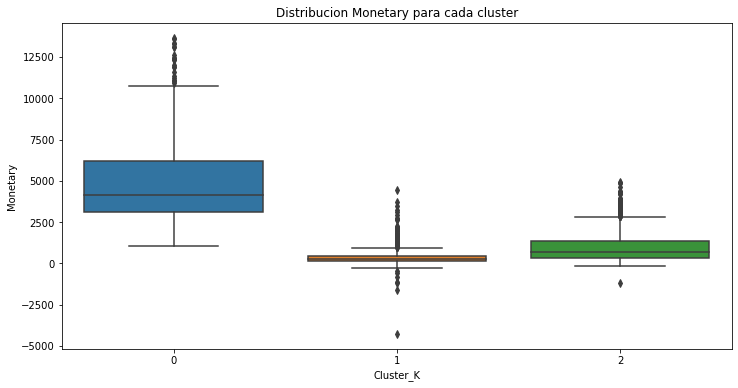

In [95]:
#  Monetary
plt.figure(figsize=(12,6))
sns.boxplot(x='Cluster_K', y='Monetary', data=rfm)
plt.title('Distribucion Monetary para cada cluster')
plt.show()

__Cluster 0:__

> Presenta la mediana más alta, con un valor alrededor de 4000$. Además muestra una mayor variablidad de gasto.

> Hay algunos clientes que han gastado más de 12000$ considerados atípicos.

> Es considerado el grupo con los clientes más valiosos debido a su alto gasto. Es el segmento perfecto para estrategias de fidelización.

__Cluster 1:__

> Presenta una mediana cercana a 0$ con una variabilidad mínima. Son clientes que gastan poco o nada.

> Hay varios clientes considerados outliers tanto positivos como negativos.

> Representan los clientes menos rentables: de una sola compra o devoluciones.


__Cluster 2:__

> La mediana está alrededor de 1000$ con un IQR más concentrado lo que genera cierta variabilidad.

> Hay algunos clientes que gastan mas de 4000$ pero tambien hay algunos que generan devoluciones representados por valores negativos.

> Es considerado el grupo de clientes regulares, con gasto estable pero no alto.




__Recency__

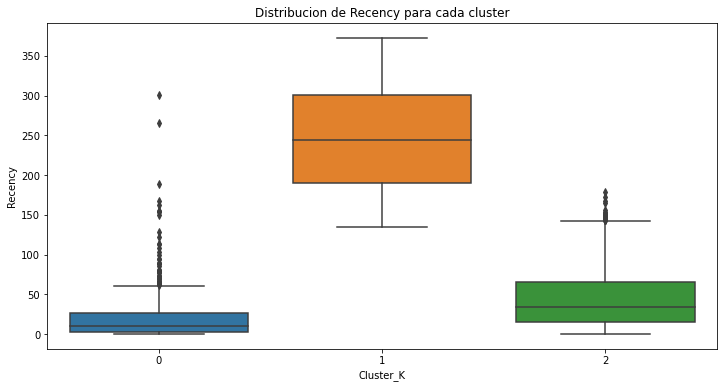

In [96]:
#  Recency
plt.figure(figsize=(12,6))
sns.boxplot(x='Cluster_K', y='Recency', data=rfm)
plt.title('Distribucion de Recency para cada cluster')
plt.show()

Es importante tener en cuenta que Recency representa el tiempo que ha pasado desde la ultima compra. Valores bajos de recency son mejores ya que indican que el cliente compro recientemente. Valores altos indican clientes inactivos.

__Cluster 0:__

> La mediana es de 10 dias y presenta una distribucion entre 0 y 30 dias.

> Es el grupo mas activo, con compra muy recientes y probablemente los mas comprometidos por lo que son ideales para campañas de fidelizacion.

__Cluster 1:__

> Presenta una mediana muy alta de aproximadamente 250 dias y una distribucion muy alta y amplia (de 90 a 360 dias).

> Son clientes inactivos o perdidos por lo que podrian necesitar de campaña de recuperacion o reactivacion.

__Cluter 2:__

> La mediana ronda los 30 dias y presenta una distribucion entre 10 y 60 dias.

> Hay algunos outliers con mas de 100 dias.

> Son clientes activos, con compras recientes 



__Frequency__

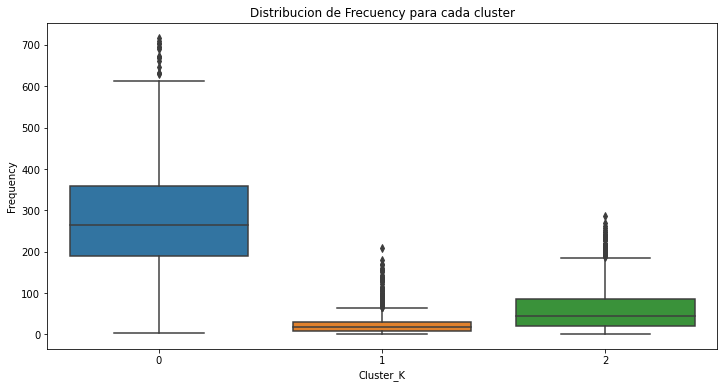

In [97]:
# Frequency
plt.figure(figsize=(12,6))
sns.boxplot(x='Cluster_K', y='Frequency', data=rfm)
plt.title('Distribucion de Frecuency para cada cluster')
plt.show()

La Frequency indica cuantas veces ha comprado un cliente. Valores altos de frequency implican clientes frecuentes.

__Cluster 0:__

> Mediana alta de aproximadamente 260, con outliers que superan las 700 veces.

> Junto con sus valores altos de Monetary y Recency baja, representan los mejores clientes.

__Cluster 1:__

> Mediana baja de 10 veces aproximadamente, con outliers por encima de 50 veces.

> Son clientes con muy poca frecuencia de compra: esporadicos, ocasionales o inactivos.

__Cluster 2:__

> Mediana de aproximadamente 50 veces con muchos outliers por encima de 200.

> Son clientes moderadamente activos, que compran varias veces pero no tan a menudo. Representan un potencial de crecimiento.


### _Conclusion final_

Segun el analisis anterior, el cluster 0 corresponde a los clientes VIP: 

- Presentan un alto gasto.
- Son lo mas activos, con la compra mas recientes.
- Hacen compras con mayor regularidad.
- Es el segmento perfecto para estrategias de fidelizacion.

El cluster 1 corresponde a los clientes inactivos o perdidos:

- Son los de bajo valor monetario.
- Son aquellos compran una vez, o generan devoluciones.
- Presentan poca frecuencia de compra.
- Ideales para campañas de recuperacion o reactivacion.

El cluster 2 correponde a los clientes regulares:

- Tienen un gasto medio bajo.
- Son activos, con compra recientes.
- Compran varias veces pero no tan a menudo.
- Ideales para campañas de crecimiento.
